In [1]:
import os
import errno
import numpy as np 
import deepcell

In [2]:
# create folder for this set of experiments
experiment_folder = "20200227_IF_Training"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [3]:
from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "20200315_IF_Training_5"
test_size=0.1
seed=0
DATA_FILE = NPZ_DIR + npz_name + ".npz"
train_dict, test_dict = get_data(DATA_FILE, test_size=test_size, seed=seed)
X_train, y_train = train_dict['X'], train_dict['y']
X_test, y_test = test_dict['X'], test_dict['y']

X.shape: (1402, 256, 256, 2)
y.shape: (1402, 256, 256, 1)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84.]


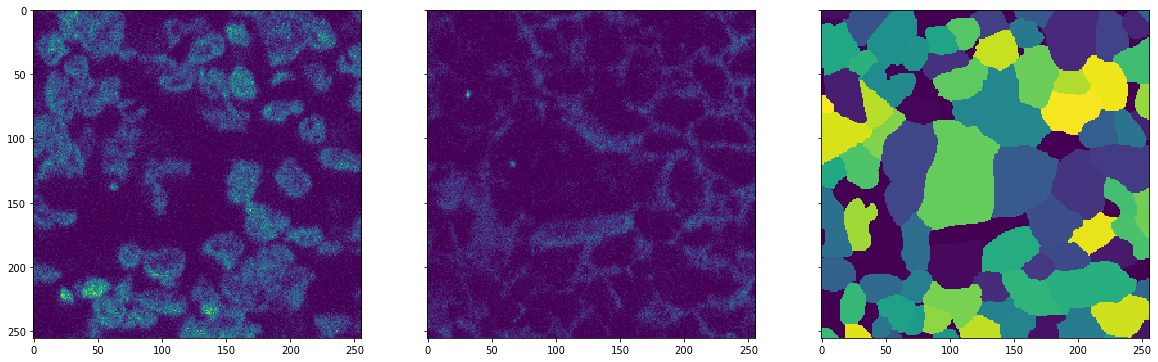

In [4]:
for i in range(y_train.shape[0]):
        y_train[i], _, _ = relabel_sequential(y_train[i])
        
for i in range(y_test.shape[0]):
        y_test[i], _, _ = relabel_sequential(y_test[i])
        
               
print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 20), sharex=True, sharey=True)
axes[0].imshow(X_train[12,:,:,0])
axes[1].imshow(X_train[12,:,:,1])
axes[2].imshow(y_train[12,:,:,0])
print(np.unique(y_train[12]))

In [5]:
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[1:],
    norm_method='std',
    num_semantic_heads=4,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

W0326 16:15:39.644400 140223233476416 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


94773248/94765736 [==============================] - 2s 0us/step


In [6]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = npz_name + '_deep_watershed'

n_epoch = 30  # Number of training epochs
test_size = .10  # % of data saved as test
norm_method = 'std'  # data normalization

optimizer = Adam(lr=1e-5, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-5, decay=0.99)

batch_size = 1

min_objects = 3  # throw out images with fewer than this many objects
seed=0
model_name

'20200315_IF_Training_5_deep_watershed'

In [7]:
from deepcell import image_generators
from deepcell.utils import train_utils


# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)
    
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=['centroid', 'watershed-cont', 'fgbg', 'pixelwise'],
    transforms_kwargs={'watershed-cont': {'erosion_width': 2}, 'pixelwise':{'dilation_radius': 1}, 
                      'centroid': {'erosion_width': 2}},
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    transforms=['centroid', 'watershed-cont', 'fgbg', 'pixelwise'],
    transforms_kwargs={'watershed-cont': {'erosion_width': 2}, 'pixelwise':{'dilation_radius': 1},
                      'centroid': {'erosion_width': 2}},
    min_objects=min_objects,
    batch_size=batch_size)

W0326 16:20:49.739073 140223233476416 semantic.py:148] Removing 99 of 1402 images with fewer than 3 objects.
W0326 16:21:15.839538 140223233476416 semantic.py:148] Removing 12 of 156 images with fewer than 3 objects.


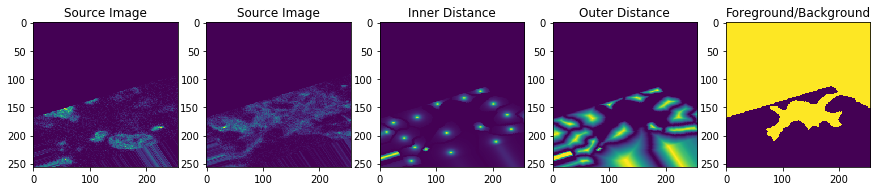

In [8]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]
#pixelwise = outputs[3]

fig, axes = plt.subplots(1, 5, figsize=(15, 15))

axes[0].imshow(img[:, :, 0])
axes[0].set_title('Source Image')

axes[1].imshow(img[:, :, 1])
axes[1].set_title('Source Image')

axes[2].imshow(inner_distance[0, ..., 0])
axes[2].set_title('Inner Distance')

axes[3].imshow(outer_distance[0, ..., 0])
axes[3].set_title('Outer Distance')

axes[4].imshow(fgbg[0, ..., 0])
axes[4].set_title('Foreground/Background')

plt.show()

In [9]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if 'semantic_' in layer.name:
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [10]:
model.compile(loss=loss, optimizer=optimizer)

In [11]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus


model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/30


W0326 16:23:02.033996 140223233476416 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


   1/1303 [..............................] - ETA: 21:29:32 - loss: 1.3525 - semantic_0_loss: 0.2825 - semantic_1_loss: 1.0453 - semantic_2_loss: 0.0114 - semantic_3_loss: 0.0132

W0326 16:24:01.611037 140223233476416 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.563337). Check your callbacks.


   2/1303 [..............................] - ETA: 10:51:15 - loss: 1.4372 - semantic_0_loss: 0.3610 - semantic_1_loss: 1.0528 - semantic_2_loss: 0.0103 - semantic_3_loss: 0.0131

W0326 16:24:01.797455 140223233476416 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.322718). Check your callbacks.


1302/1303 [============================>.] - ETA: 0s - loss: 0.1811 - semantic_0_loss: 0.0280 - semantic_1_loss: 0.1387 - semantic_2_loss: 0.0052 - semantic_3_loss: 0.0092
Epoch 00001: val_loss improved from inf to 14.17299, saving model to /data/models/20200227_IF_Training/20200315_IF_Training_5_deep_watershed.h5
1303/1303 [==============================] - 404s 310ms/step - loss: 0.1810 - semantic_0_loss: 0.0280 - semantic_1_loss: 0.1386 - semantic_2_loss: 0.0052 - semantic_3_loss: 0.0092 - val_loss: 14.1730 - val_semantic_0_loss: 0.0722 - val_semantic_1_loss: 14.0833 - val_semantic_2_loss: 0.0074 - val_semantic_3_loss: 0.0101
Epoch 2/30
1302/1303 [============================>.] - ETA: 0s - loss: 0.0609 - semantic_0_loss: 0.0120 - semantic_1_loss: 0.0369 - semantic_2_loss: 0.0041 - semantic_3_loss: 0.0079
Epoch 00002: val_loss improved from 14.17299 to 6.20968, saving model to /data/models/20200227_IF_Training/20200315_IF_Training_5_deep_watershed.h5
1303/1303 [=====================

1302/1303 [============================>.] - ETA: 0s - loss: 0.0458 - semantic_0_loss: 0.0092 - semantic_1_loss: 0.0267 - semantic_2_loss: 0.0031 - semantic_3_loss: 0.0068
Epoch 00014: val_loss did not improve from 0.05336
1303/1303 [==============================] - 250s 192ms/step - loss: 0.0458 - semantic_0_loss: 0.0092 - semantic_1_loss: 0.0267 - semantic_2_loss: 0.0031 - semantic_3_loss: 0.0068 - val_loss: 0.0537 - val_semantic_0_loss: 0.0100 - val_semantic_1_loss: 0.0296 - val_semantic_2_loss: 0.0051 - val_semantic_3_loss: 0.0090
Epoch 15/30
1302/1303 [============================>.] - ETA: 0s - loss: 0.0457 - semantic_0_loss: 0.0092 - semantic_1_loss: 0.0266 - semantic_2_loss: 0.0031 - semantic_3_loss: 0.0068
Epoch 00015: val_loss did not improve from 0.05336
1303/1303 [==============================] - 251s 193ms/step - loss: 0.0457 - semantic_0_loss: 0.0092 - semantic_1_loss: 0.0266 - semantic_2_loss: 0.0031 - semantic_3_loss: 0.0068 - val_loss: 0.0542 - val_semantic_0_loss: 0

Epoch 29/30
1302/1303 [============================>.] - ETA: 0s - loss: 0.0426 - semantic_0_loss: 0.0085 - semantic_1_loss: 0.0247 - semantic_2_loss: 0.0029 - semantic_3_loss: 0.0065
Epoch 00029: val_loss did not improve from 0.04920
1303/1303 [==============================] - 249s 191ms/step - loss: 0.0427 - semantic_0_loss: 0.0085 - semantic_1_loss: 0.0248 - semantic_2_loss: 0.0029 - semantic_3_loss: 0.0065 - val_loss: 0.0522 - val_semantic_0_loss: 0.0096 - val_semantic_1_loss: 0.0265 - val_semantic_2_loss: 0.0059 - val_semantic_3_loss: 0.0103
Epoch 30/30
1302/1303 [============================>.] - ETA: 0s - loss: 0.0421 - semantic_0_loss: 0.0085 - semantic_1_loss: 0.0243 - semantic_2_loss: 0.0029 - semantic_3_loss: 0.0065
Epoch 00030: val_loss did not improve from 0.04920
1303/1303 [==============================] - 250s 192ms/step - loss: 0.0421 - semantic_0_loss: 0.0085 - semantic_1_loss: 0.0243 - semantic_2_loss: 0.0029 - semantic_3_loss: 0.0065 - val_loss: 0.0548 - val_semant